# Functionality for plotting synthetic data results

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pickle
import numpy as np
from numpy.linalg import LinAlgError
import pandas as pd

# utils for plotting
import plotly.graph_objects as go
import plotly.express as px
import plotly.colors as colors
from plotly.subplots import make_subplots
from matplotlib import pyplot as plt

from helpers import (get_ablation_scores, 
                     get_scores,
                     plot_matplotlib,
                     plot_plotly)

In [3]:
ground_truth ='sinexp' # 'sum_gauss'
d = 1
logn_lo = 8
logn_hi = 14
n_trials = 100
# !!! MAKE SURE TO SET THE RIGHT BASELINE LOSS !!! 
baseline_loss = 1 # = noise**2

# output_dir = 'output_rebuttal_fig2'
output_dir = 'output_rebuttal_fig2-2'
fig_dir = os.path.join(output_dir, f'd={d}', 'figures') # directory to save figures
score_dir = os.path.join(output_dir, f'd={d}', 'scores_cv') # directory with saved scores

## Figure 1: Plot test function

In [4]:
# sample synthetic data
from npr.util_sample import ToyData
X_name = 'unif'
toy_data_noise = ToyData(
    X_name=X_name, 
    f_name=ground_truth,
    noise=1.,
    d=d, 
    # k=1, #number of anchor points
    # k=8,
    # scale=8,
)

seed = 123
# X_train, y_train = toy_data_noise.sample(n)
X_test, y_test = toy_data_noise.sample(10000, seed=seed, shuffle=False)
print(X_test.shape, y_test.shape)
# validation set used for cross validation
# set different seed so that val and test data and different
X_val, y_val = toy_data_noise.sample(10000, seed=seed*2, shuffle=True)
print(X_val.shape, y_val.shape)

(10000, 1) (10000,)
(10000, 1) (10000,)


In [5]:
fig = px.scatter(x=X_val[:,0], y=y_val,
                # title=f'X={X_name}, f={ground_truth}, std[f]={np.std(y_val):.4f}',
                opacity=0.5,
                )
fig.update_layout(
    # title=f'X={X_name}, f={ground_truth}, std[f]={np.std(y_val):.4f}',
    # xaxis_title="X",
    # yaxis_title="y",
    width=800,
    height=600,
)

In [6]:
# # save fig to file
# fig_file = os.path.join(
#     fig_dir,
#     f"X={X_name}-f={ground_truth}-n=10000.png"
# )
# fig.write_image(fig_file)

## Load results

In [7]:
# nadaraya watson
method = 'nw'
# kernel = 'epanechnikov'
kernel = 'wendland'
nw_ablation_scores, nw_ablation_names = get_ablation_scores(score_dir, method, kernel, ground_truth, logn_lo, logn_hi, n_trials)
nw_scores, nw_names = get_scores(score_dir, method, kernel, ground_truth, logn_lo, logn_hi, n_trials)
all_nw_scores = nw_scores + nw_ablation_scores
all_nw_names = nw_names + nw_ablation_names
print(all_nw_names)

['full', 'rpcholesky', 'st', 'k_RR', 'k(x1,x2)', 'k((x1,x2), (y1,y2))', 'k_NW']


In [8]:
# kernel ridge regression
method = 'krr'
kernel = 'gaussian'
krr_ablation_scores, krr_ablation_names = get_ablation_scores(score_dir, method, kernel, ground_truth, logn_lo, logn_hi, n_trials)
krr_scores, krr_names = get_scores(score_dir, method, kernel, ground_truth, logn_lo, logn_hi, n_trials)
all_krr_scores = krr_scores + krr_ablation_scores
all_krr_names = krr_names + krr_ablation_names
print(all_krr_names)

['full', 'rpcholesky', 'st', 'k_NW', 'k(x1,x2)', 'k((x1,x2), (y1,y2))', 'k_RR']


In [9]:
krr_ablation_names

['k_NW', 'k(x1,x2)', 'k((x1,x2), (y1,y2))', 'k_RR']

## Figure 2: Plotly version

In [10]:
# fig = go.Figure()
fig = make_subplots(rows=1, cols=2, 
                    subplot_titles=('Nadaraya-Watson (Epanechnikov)', 'Kernel Ridge Regression (Gaussian)'),
                    shared_yaxes=True)

colors_list = colors.qualitative.Plotly * 4
colors_used = {}

In [11]:

scale = 'log2'

def plot(all_scores, ablation_names, row=1, col=1):
    for result in all_scores:
        name = result['name']
        # color = colors_list[all_names.index(name)]
        if name in colors_used:
            color = colors_used[name]
        else:
            color = colors_list[len(colors_used)]
        # print(name, result['logn'], np.mean(result["scores"]))
        excess_risk = np.array(result["scores"]) - baseline_loss

        if scale == 'log2':
            y = np.log2(excess_risk)
            # hline = np.log2(np.abs(baseline_loss))

        elif scale == 'linear':
            y = excess_risk
            # hline = np.abs(baseline_loss)
        trace = go.Box(
            x=[result['logn']]*len(result["scores"]),
            y=y,
            name=name,
            # opacity=0.5,
            legendgroup=name,
            line_color=color,
            offsetgroup=name,
            showlegend=name not in colors_used,
            boxmean=True,
            notched=name in ablation_names,
            opacity=0.5 if name in ablation_names else 1.,
        )

        fig.add_trace(trace, row=row, col=col)
        # colors_used.add(color)
        colors_used[name] = color


In [12]:
plot(all_nw_scores, ablation_names=['k(x1,x2)', 'k((x1,x2), (y1,y2))', 'k_RR'], row=1, col=1)
plot(all_krr_scores, ablation_names=['k(x1,x2)', 'k((x1,x2), (y1,y2))', 'k_NW'], row=1, col=2)

/tmp/ipykernel_3734746/417684315.py:15: RuntimeWarning:

invalid value encountered in log2



In [13]:
colors_used

{'full': '#636EFA',
 'rpcholesky': '#EF553B',
 'st': '#00CC96',
 'k_RR': '#AB63FA',
 'k(x1,x2)': '#FFA15A',
 'k((x1,x2), (y1,y2))': '#19D3F3',
 'k_NW': '#FF6692'}

In [14]:
fig.update_yaxes(
    title_text=f"{scale}(excess risk)", 
    row=1, col=1,
    showline=True,
    linewidth=2,
)
fig.update_xaxes(
    title_text="log2(n)", 
    type='linear',
    showline=True,
    linewidth=2,
)
fig.update_layout(
    width=1500,
    height=600,
    # title=f"Excess risk vs n (ground_truth={ground_truth})",
    boxmode='group',
    font=dict(
        # family="Courier New, monospace",
        size=18,
    ),
    # plot_bgcolor='rgba(0, 0, 200, 0.5)',  # Light gray background with 50% opacity
    plot_bgcolor='rgba(0, 0, 0, 0)',  # Light gray background with 50% opacity
    # set x and y axis color
    # xaxis=dict(
    #     linecolor='black',
    #     linewidth=2,
    #     mirror=True,
    #     showgrid=True,
    # ),
    # yaxis=dict(
    #     linecolor='black',
    #     linewidth=2,
    #     mirror=True,
    #     showgrid=True,
    # ),
)

In [15]:
# # save fig to file
# os.makedirs(fig_dir, exist_ok=True)
# fig_file = os.path.join(
#     fig_dir,
#     f"all-gt={ground_truth}-logn={logn_lo}_{logn_hi}-t{n_trials}-excess.png"
# )
# fig.write_image(fig_file)

## Figure 2: Matplotlib version

https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html

https://matplotlib.org/stable/gallery/statistics/boxplot_color.html#sphx-glr-gallery-statistics-boxplot-color-py

In [16]:
# # make a matplotlib version of the above figure
# import matplotlib.pyplot as plt
# from matplotlib.patches import Patch

# def plot_matplotlib(all_scores, all_names, ablation_names, legend_names, ax, f):
#     """
#     Plot box plot in matplotlib
    
#     Args:
#     all_scores: list of dictionaries with keys 'name', 'logn', 'scores'
#     all_names: list of names of methods
#     ablation_names: list of names of ablation methods
#     legend_names: dictionary mapping method names to legend names
#     ax: matplotlib axis
#     f: function that takes in a result and outputs an 1D array
#     """
#     offset = 2
#     colors = []
#     ys = []
#     positions = []
#     hatches = []
#     alphas = []
#     for result in all_scores:
#         name = result['name']
#         i = all_names.index(name)
#         color = colors_list[i]
#         hatch = '.' if name in ablation_names else None
#         # excess_risk = np.array(result["scores"]) - baseline_loss
#         excess_risk = f(result)
#         # print(name, result['logn'], i)
#         position = result['logn'] * len(all_names) + 1.5*i + offset
#         alpha = 0.25 if name in ablation_names else 1.
#         # alpha=1

#         y = np.log2(excess_risk)
#         ys.append(y)
#         positions.append(position)
#         colors.append(color)
#         hatches.append(hatch)
#         alphas.append(alpha)

#     bplot = ax.boxplot(
#         ys,
#         patch_artist=True,  # fill with color
#         positions=positions,
#         widths=1.2,
#         # don't show outliers
#         showfliers=False,
#         showmeans=True,
#         meanline=True,
#         meanprops=dict(
#             color='black', # set mean line color
#         ),  
#         medianprops=dict(color='black'),  # set median line color
#     )
#     # fill with colors
#     for patch, color, hatch, alpha in zip(bplot['boxes'], colors, hatches, alphas):
#         patch.set_facecolor(color)
#         # patch.set_hatch(hatch)
#         patch.set_alpha(alpha)
#         # set mean line color

#     ax.set_xlabel("$n$", fontsize=16)
#     ax.set_ylabel(f"$\log_2(excess~risk)$", fontsize=16)
#     # add grid lines along y axis
#     ax.yaxis.grid(True)
#     # set the x-axis labels
#     xticks = [(logn +1)* len(all_names) for logn in range(logn_lo, logn_hi+1,2)]
#     print(xticks)
#     ax.set_xticks(xticks)
#     ax.set_xticklabels(["$2^{%d}$" % (logn) for logn in range(logn_lo, logn_hi+1,2)])
#     # set ylim
#     ax.set_ylim(-9, 2)

#     # ax.legend(handles=[Patch(color=color, label=name)])
#     # add legend
#     ax.legend(
#         handles=[Patch(color=colors_list[i], label=legend_names[name], alpha=0.25 if name in ablation_names else 1) for i,name in enumerate(all_names)],
#         loc='lower left',
#         # bbox_to_anchor=(1, 1),
#     )
#     # set title
#     # ax.set_title(f"Excess risk vs n (ground_truth={ground_truth})")
#     # add dashed vertical lines
#     for logn in range(logn_lo, logn_hi+1, 2):
#         ax.axvline((logn+0.)*len(all_names), color='black', linestyle='--', linewidth=0.5, dashes=(5, 5))
# print(all_nw_names)


In [17]:
colors_list = ['black', 'red', 'green', 'yellow', 'orange', 'brown', 'cyan']
nw_colors_list = ['black', 'red', 'green', 'yellow', 'orange', 'brown', 'cyan']
krr_colors_list = ['black', 'red', 'green', 'cyan', 'orange', 'brown', 'yellow']
legend_names = {
    'full': 'Full',
    'st': 'ST',
    'rpcholesky': 'RPCholesky',
    'k(x1,x2)': 'KT w/ $\mathbf{k}(x_1,x_2)$',
    'k((x1,x2), (y1,y2))': 'KT w/ $\mathbf{k}((x_1\oplus y_1), (x_2\oplus y_2))$',
    'k_RR': 'KT w/ $\mathbf{k}_{\mathrm{RR}}((x_1,y_1),(x_2,y_2))$',
    'k_NW': 'KT w/ $\mathbf{k}_{\mathrm{NW}}((x_1,y_1),(x_2,y_2))$',
}

### Figure 2a

/share/nikola/ag2435/kt_regression/src/npr/examples/neurips/helpers.py:239: RuntimeWarning:

invalid value encountered in log2



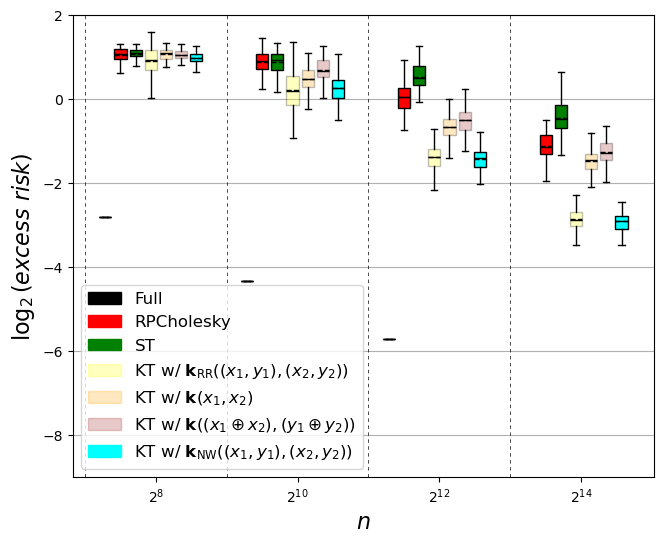

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 6))
plot_matplotlib(
    ax,
    all_nw_scores, 
    lambda result: np.array(result["scores"]) - baseline_loss,
    all_nw_names,
    ablation_names=['k(x1,x2)', 'k((x1,x2), (y1,y2))', 'k_RR'], 
    legend_names=legend_names, 
    colors_list=nw_colors_list,
)
# add grid lines along y axis
ax.yaxis.grid(True)
# set ylim
ax.set_ylim(-9, 2)
ax.set_ylabel(f"$\log_2(excess~risk)$", fontsize=16)
plt.show()

In [19]:
# print table of results
def get_results_df(all_scores, f, ablation_names=[]):
    results = []
    for result in all_scores:
        logn = result['logn']
        name = result['name']
        if name in ablation_names:
            continue
        y = f(result)
        mean = np.mean(y)
        std = np.std(y)
        results.append({
            'logn' : logn,
            'name': name,
            # 'mean': mean,
            # 'std': std,
            'mean_std': f"{mean:.4f} ± {std:.4f}",
        })
    return pd.DataFrame(results)

In [20]:
df_nw = get_results_df(all_nw_scores, lambda result: np.array(result["scores"]) - baseline_loss,)
# convert df to table with name as index and logn as columns
df_nw = df_nw.pivot(index='name', columns='logn', values='mean_std')
# reorder rows by the order of all_nw_names
df_nw = df_nw.loc[all_nw_names]
# rename names with legend_names map
df_nw.index = [legend_names[name] for name in df_nw.index]
# rename columns with the map logn -> 2^logn
df_nw.columns = ["$n=2^{%d}$" % logn for logn in df_nw.columns]

In [21]:
df_nw

$n=2^{8}$  \
Full                                                0.1423 ± 0.0000   
RPCholesky                                          2.0737 ± 0.2548   
ST                                                  2.1181 ± 0.1813   
KT w/ $\mathbf{k}_{\mathrm{RR}}((x_1,y_1),(x_2,...  1.9203 ± 0.4216   
KT w/ $\mathbf{k}(x_1,x_2)$                         2.1040 ± 0.1928   
KT w/ $\mathbf{k}((x_1\oplus x_2), (y_1\oplus y...  2.0814 ± 0.1648   
KT w/ $\mathbf{k}_{\mathrm{NW}}((x_1,y_1),(x_2,...  1.9838 ± 0.2056   

                                                         $n=2^{10}$  \
Full                                                0.0494 ± 0.0000   
RPCholesky                                          1.8583 ± 0.3150   
ST                                                  1.8844 ± 0.3063   
KT w/ $\mathbf{k}_{\mathrm{RR}}((x_1,y_1),(x_2,...  1.2230 ± 0.4160   
KT w/ $\mathbf{k}(x_1,x_2)$                         1.4149 ± 0.2585   
KT w/ $\mathbf{k}((x_1\oplus x_2), (y_1\oplus y...  1.6633 ± 0.3603   
KT w/ $\mathbf{k}_{\mathrm{NW}}((x_1,y_1),(x_2,...  1.2423 ± 0.3736   

                                                         $n=2^{12}$  \
Full                                                0.0189 ± 0.0000   
RPCholesky                                          1.0772 ± 0.2920   
ST                                                  1.4720 ± 0.3058   
KT w/ $\mathbf{k}_{\mathrm{RR}}((x_1,y_1),(x_2,...  0.3952 ± 0.0955   
KT w/ $\mathbf{k}(x_1,x_2)$                         0.6458 ± 0.1386   
KT w/ $\mathbf{k}((x_1\oplus x_2), (y_1\oplus y...  0.7260 ± 0.1791   
KT w/ $\mathbf{k}_{\mathrm{NW}}((x_1,y_1),(x_2,...  0.3799 ± 0.0808   

                                                          $n=2^{14}$  
Full                                                -0.0003 ± 0.0000  
RPCholesky                                           0.4720 ± 0.1026  
ST                                                   0.7632 ± 0.2364  
KT w/ $\mathbf{k}_{\mathrm{RR}}((x_1,y_1),(x_2,...   0.1403 ± 0.0274  
KT w/ $\mathbf{k}(x_1,x_2)$                          0.3679 ± 0.0705  
KT w/ $\mathbf{k}((x_1\oplus x_2), (y_1\oplus y...   0.4282 ± 0.0825  
KT w/ $\mathbf{k}_{\mathrm{NW}}((x_1,y_1),(x_2,...   0.1363 ± 0.0267

In [22]:
print(df_nw.to_markdown())

|                                                       | $n=2^{8}$       | $n=2^{10}$      | $n=2^{12}$      | $n=2^{14}$       |
|:------------------------------------------------------|:----------------|:----------------|:----------------|:-----------------|
| Full                                                  | 0.1423 ± 0.0000 | 0.0494 ± 0.0000 | 0.0189 ± 0.0000 | -0.0003 ± 0.0000 |
| RPCholesky                                            | 2.0737 ± 0.2548 | 1.8583 ± 0.3150 | 1.0772 ± 0.2920 | 0.4720 ± 0.1026  |
| ST                                                    | 2.1181 ± 0.1813 | 1.8844 ± 0.3063 | 1.4720 ± 0.3058 | 0.7632 ± 0.2364  |
| KT w/ $\mathbf{k}_{\mathrm{RR}}((x_1,y_1),(x_2,y_2))$ | 1.9203 ± 0.4216 | 1.2230 ± 0.4160 | 0.3952 ± 0.0955 | 0.1403 ± 0.0274  |
| KT w/ $\mathbf{k}(x_1,x_2)$                           | 2.1040 ± 0.1928 | 1.4149 ± 0.2585 | 0.6458 ± 0.1386 | 0.3679 ± 0.0705  |
| KT w/ $\mathbf{k}((x_1\oplus x_2), (y_1\oplus y_2))$  | 2.0814 ± 0.1648 | 1.6633 

### Figure 2b

/share/nikola/ag2435/kt_regression/src/npr/examples/neurips/helpers.py:239: RuntimeWarning:

invalid value encountered in log2



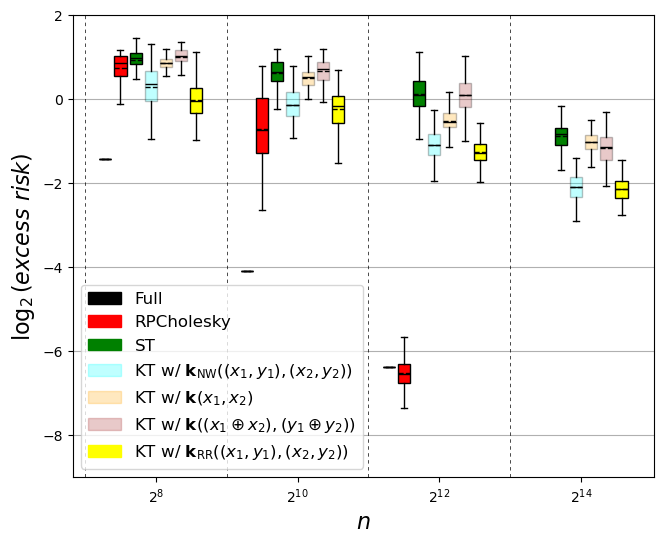

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 6))
plot_matplotlib(
    ax,
    all_krr_scores, 
    lambda result: np.array(result["scores"]) - baseline_loss,
    all_krr_names, 
    ['k(x1,x2)', 'k((x1,x2), (y1,y2))', 'k_NW'], 
    legend_names,
    krr_colors_list
)
# add grid lines along y axis
ax.yaxis.grid(True)
# set ylim
ax.set_ylim(-9, 2)
ax.set_ylabel(f"$\log_2(excess~risk)$", fontsize=16)
plt.show()

In [24]:

# fig_file = os.path.join(
#     fig_dir,
#     f"all-k={kernel}-gt={ground_truth}-logn={logn_lo}_{logn_hi}-t{n_trials}-excess-2-matplotlib.png"
# )
# fig.savefig(fig_file)

In [26]:
df_krr = get_results_df(all_krr_scores, lambda result: np.array(result["scores"]) - baseline_loss,)
# convert df to table with name as index and logn as columns
df_krr = df_krr.pivot(index='name', columns='logn', values='mean_std')
# reorder rows by the order of all_krr_names
df_krr = df_krr.loc[all_krr_names]
# rename names with legend_names map
df_krr.index = [legend_names[name] for name in df_krr.index]
# rename columns with the map logn -> 2^logn
df_krr.columns = ["$n=2^{%d}$" % logn for logn in df_krr.columns]

In [27]:
# print table as markdown
print(df_krr.to_markdown())

|                                                       | $n=2^{8}$       | $n=2^{10}$      | $n=2^{12}$      | $n=2^{14}$       |
|:------------------------------------------------------|:----------------|:----------------|:----------------|:-----------------|
| Full                                                  | 0.3750 ± 0.0000 | 0.0584 ± 0.0000 | 0.0121 ± 0.0000 | -0.0019 ± 0.0000 |
| RPCholesky                                            | 1.7112 ± 0.3636 | 0.7153 ± 0.3839 | 0.0112 ± 0.0029 | -0.0020 ± 0.0000 |
| ST                                                    | 1.9433 ± 0.3129 | 1.5855 ± 0.3570 | 1.1328 ± 0.3374 | 0.5634 ± 0.1437  |
| KT w/ $\mathbf{k}_{\mathrm{NW}}((x_1,y_1),(x_2,y_2))$ | 1.3068 ± 0.4381 | 0.9520 ± 0.2783 | 0.4859 ± 0.1146 | 0.2394 ± 0.0538  |
| KT w/ $\mathbf{k}(x_1,x_2)$                           | 1.8103 ± 0.1677 | 1.4297 ± 0.2559 | 0.7077 ± 0.1433 | 0.4974 ± 0.0885  |
| KT w/ $\mathbf{k}((x_1\oplus x_2), (y_1\oplus y_2))$  | 2.0312 ± 0.2431 | 1.6189 

## Figure 3: NW times

### Figure 3a: Training

In [26]:
fig = plot_plotly(
        all_nw_scores, 
        lambda f : np.array(f["train_times"]),
        include_names=['full', 'st', 'rpcholesky', 'k_NW'],
        scale='log2',
)
fig.update_yaxes(title_text='log2(train time)', type='linear')
fig.update_layout(
    title=f"Train times vs n (kernel={kernel}, ground_truth={ground_truth})",
)
fig.show()

In [27]:
# # plot line of train time vs n
# px.scatter(
#     x=[result['logn'] for result in all_nw_scores],
#     y=[np.mean(result["train_times"]) for result in all_nw_scores],
#     color=[result['name'] for result in all_nw_scores],
#     labels={'x': 'log2(n)', 'y': 'train time'},
#     title=f"Train times vs n (kernel={kernel}, ground_truth={ground_truth})",
# )

In [28]:
from matplotlib.patches import Patch

from collections import defaultdict

def plot_matplotlib_lines(ax, all_scores, f, include_names=None):
    lines = defaultdict(lambda: {'x': [], 'y': [], 'yerr': []})
    for result in all_scores:
        name = result['name']
        # y = np.log2(result["train_times"])
        y = f(result)
        x = result['logn']
        lines[name]['x'].append(x)
        lines[name]['y'].append(np.mean(y))
        lines[name]['yerr'].append(np.std(y))
    handles = []
    for name, line in lines.items():
        if include_names and name not in include_names:
            continue
        color = colors_list[all_nw_names.index(name)]
        ax.plot(
            line['x'], 
            line['y'], 
            label=name,
            linewidth=2,
            color=color,
            marker='>'
        )
        for x, y, yerr in zip(line['x'], line['y'], line['yerr']):
            ax.errorbar(x, y, yerr=yerr, fmt='-', color=color)
        handles.append(Patch(color=color, label=legend_names[name]))
    return handles

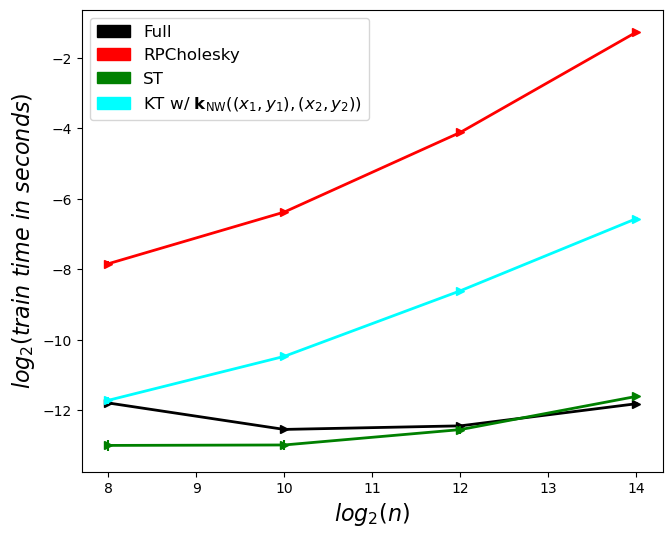

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 6))
# plot lines of train time vs n
handles = plot_matplotlib_lines(
    ax,
    all_nw_scores, 
    lambda result : np.log2(result["train_times"]),
    include_names=['full', 'st', 'rpcholesky', 'k_NW'],
)
# add legend
ax.legend(
    handles=handles,
    loc='upper left',
    fontsize='large',
)
ax.set_xlabel("$log_2(n)$", fontsize=16)
ax.set_ylabel("$log_2(train~time~in~seconds)$", fontsize=16)
plt.show()

In [30]:
# # matplotlib version
# fig, ax = plt.subplots(1, 1, figsize=(7.5, 6))
# plot_matplotlib(
#     ax,
#     all_nw_scores, 
#     lambda result: np.array(result["train_times"]),
#     all_nw_names,
#     ablation_names=['k(x1,x2)', 'k((x1,x2), (y1,y2))', 'k_RR'], 
#     legend_names=legend_names, 
#     colors_list=colors_list,
# )
# plt.show()

In [31]:
# # save fig to file
# fig_file = os.path.join(
#     fig_dir,
#     f"train_time-{method}-k={kernel}-gt={ground_truth}-logn={logn_lo}_{logn_hi}-t{n_trials}.png"
# )
# fig.write_image(fig_file)

### Figure 3b: Testing

In [32]:
fig = plot_plotly(
        all_nw_scores, 
        lambda f : np.array(f["test_times"]),
        include_names=['full', 'st', 'rpcholesky', 'k_NW'],
        scale='log2',
)
fig.update_yaxes(title_text='log2(test time)', type='linear')
fig.update_layout(
    title=f"Test times vs n (kernel={kernel}, ground_truth={ground_truth})",
)
fig.show()

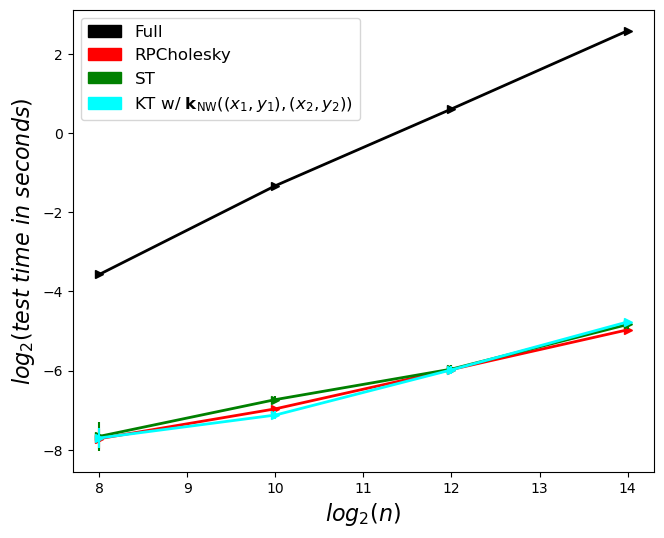

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 6))
# plot lines of train time vs n
handles = plot_matplotlib_lines(
    ax,
    all_nw_scores, 
    lambda result : np.log2(result["test_times"]),
    include_names=['full', 'st', 'rpcholesky', 'k_NW'],
)
# add legend
ax.legend(
    handles=handles,
    loc='upper left',
    fontsize='large',
)
ax.set_xlabel("$log_2(n)$", fontsize=16)
ax.set_ylabel("$log_2(test~time~in~seconds)$", fontsize=16)
plt.show()

## Figure 4: KRR times

### Figure 4a: Training

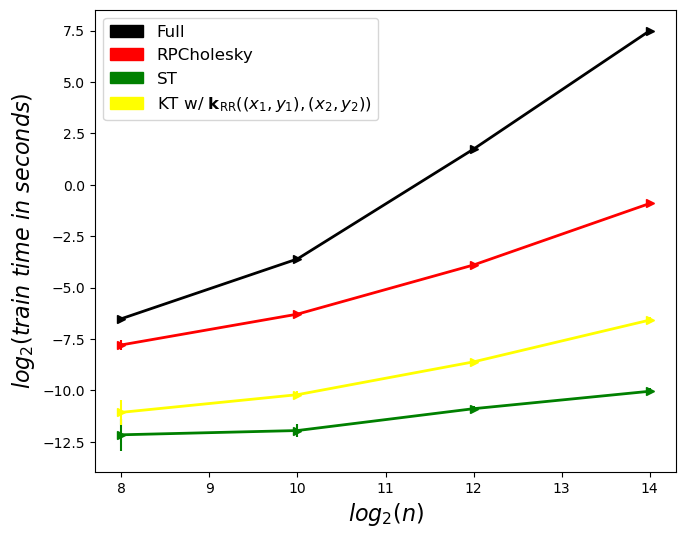

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 6))
# plot lines of train time vs n
handles = plot_matplotlib_lines(
    ax,
    all_krr_scores, 
    lambda result : np.log2(result["train_times"]),
    include_names=['full', 'st', 'rpcholesky', 'k_RR'],
)
# add legend
ax.legend(
    handles=handles,
    loc='upper left',
    fontsize='large',
)
ax.set_xlabel("$log_2(n)$", fontsize=16)
ax.set_ylabel("$log_2(train~time~in~seconds)$", fontsize=16)
plt.show()

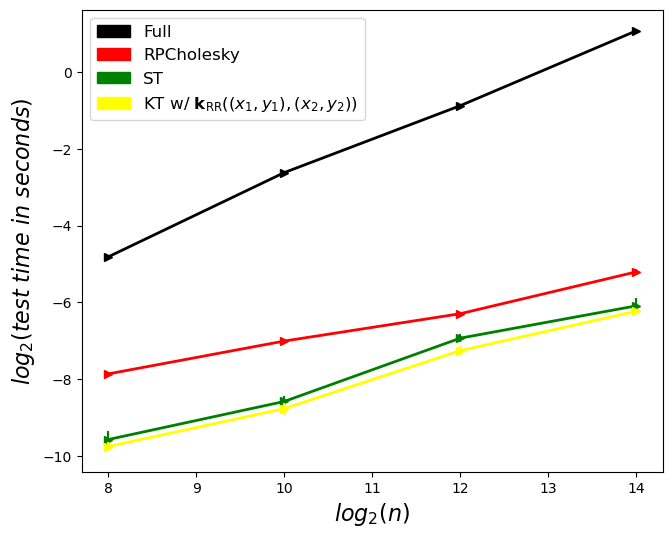

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 6))
# plot lines of train time vs n
handles = plot_matplotlib_lines(
    ax,
    all_krr_scores, 
    lambda result : np.log2(result["test_times"]),
    include_names=['full', 'st', 'rpcholesky', 'k_RR'],
)
# add legend
ax.legend(
    handles=handles,
    loc='upper left',
    fontsize='large'
)
ax.set_xlabel("$log_2(n)$", fontsize=16)
ax.set_ylabel("$log_2(test~time~in~seconds)$", fontsize=16)
plt.show()